In [1]:
import sys
import sklearn
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import tarfile
import urllib

DOWNOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Saving figure attribute_histogram_plots


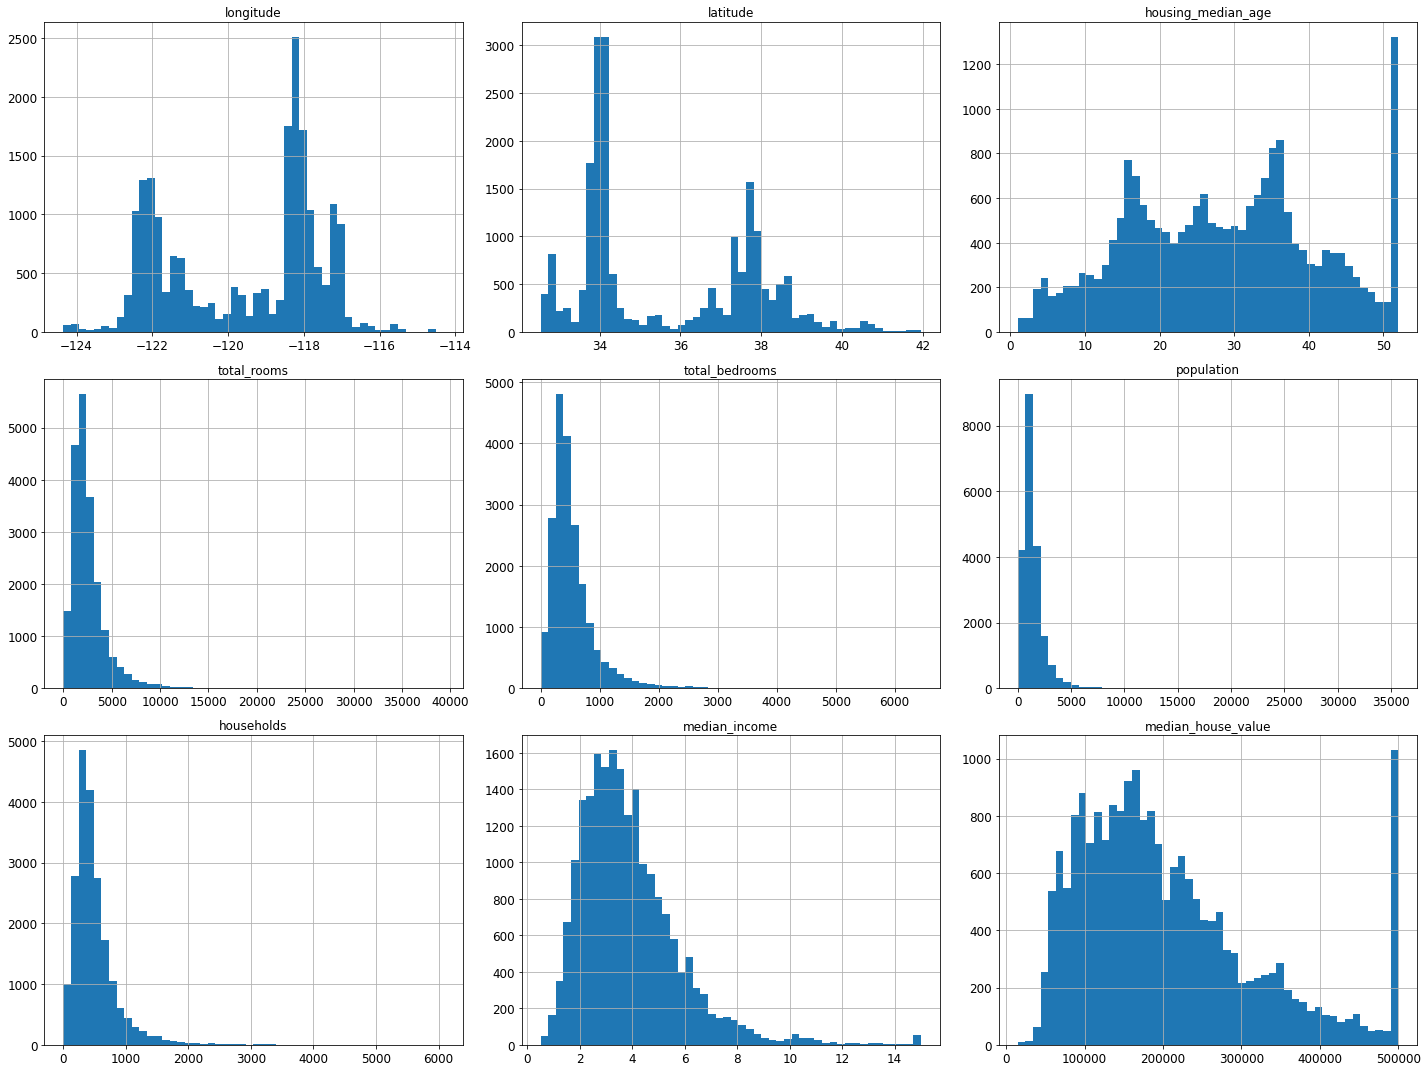

In [9]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [10]:
np.random.seed(42)

In [11]:
def split_train_test(data, test_ratio):
    suffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = suffled_indices[:test_set_size]
    train_indices = suffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [17]:
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
59     59    -122.29     37.82                 2.0        158.0   
60     60    -122.29     37.83                52.0       1121.0   
61     61    -122.29     37.82                49.0        135.0   
62     62    -122.29     37.81                50.0        760.0   
67     67    -122.29     37.80                52.0       1027.0   

    total_bedrooms  population  households  median_income  median_house_value  \
59            43.0        94.0        57.0         2.5625             60000.0   
60           211.0       554.0       187.0         3.3929             75700.0   
61            29.0        86.0        23.0         6.1183             75000.0   
62           190.0       377.0       122.0         0.9011             86100.0   
67           244.0       492.0       147.0         2.6094             81300.0   

   ocean_proximity         id  
59        NEAR BAY -122252.18  
60        NEAR BAY -122252.17  
61        NEAR BAY -122252.18  
62        NEAR BAY -122252.19  
67        NEAR BAY -122252.20

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

<AxesSubplot:>

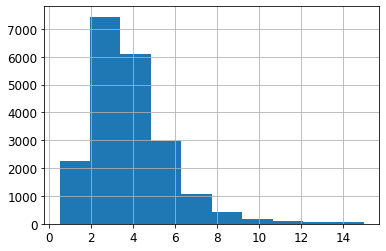

In [20]:
housing["median_income"].hist()

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

In [22]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

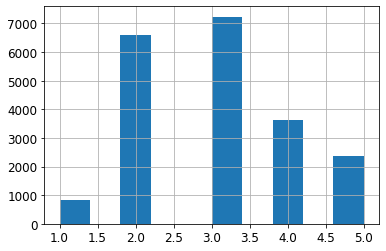

In [23]:
housing["income_cat"].hist()

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [27]:
compare_props

Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011

In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to get insights

In [29]:
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


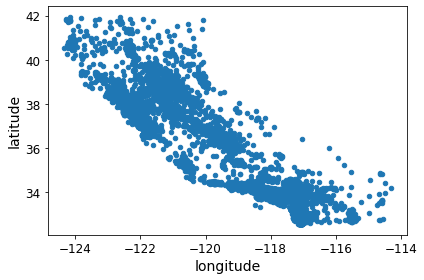

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


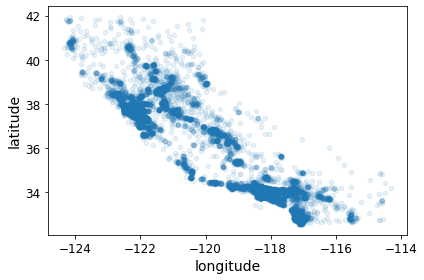

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


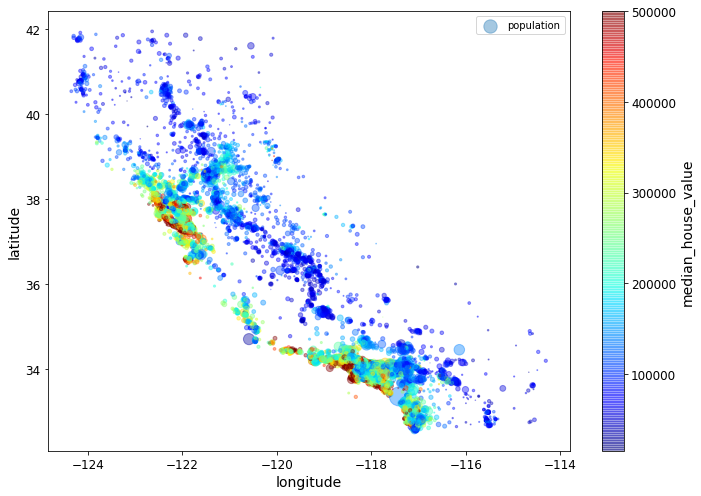

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density.

In [33]:
# Download the California image

images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x215adcfbc10>)

Saving figure california_housing_prices_plot


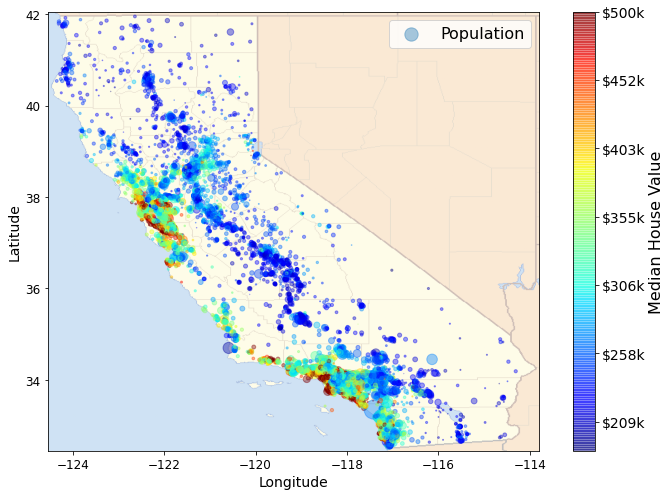

In [34]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [35]:
corr_matrix = housing.corr()

In [36]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


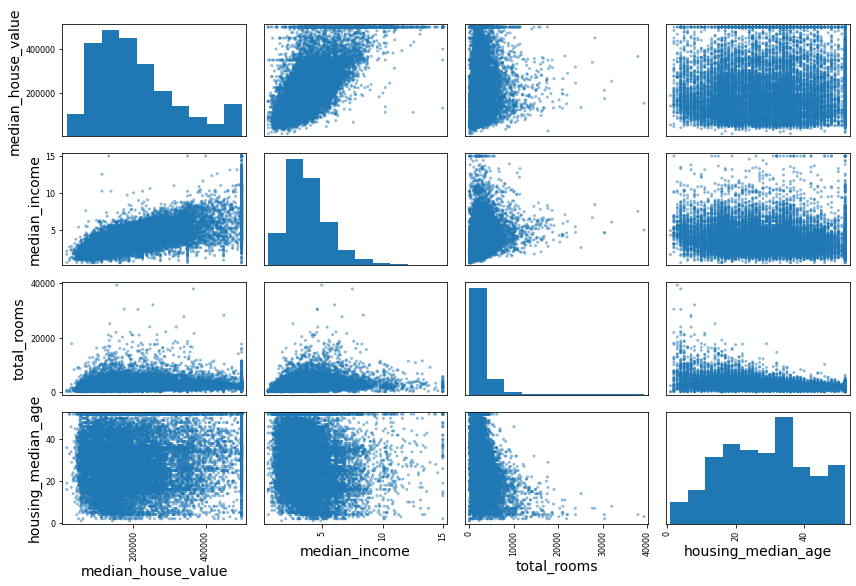

In [37]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


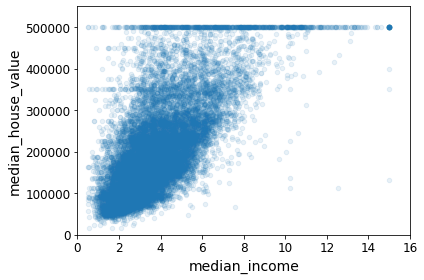

In [38]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [39]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  
count        16512.000000  
mean        206990.920724  
std         115703.014830  
min          14999.000000  
25%         119800.000000  
50%         179500.000000  
75%         263900.000000  
max         500001.000000

In [40]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [41]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

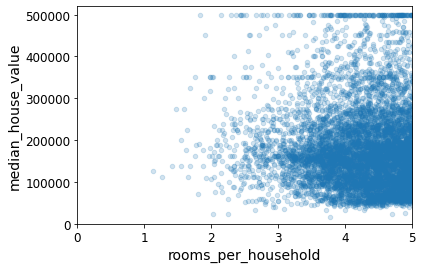

In [42]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [43]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.575834     35.639577           28.653101   2622.728319   
std        2.001860      2.138058           12.574726   2138.458419   
min     -124.350000     32.540000            1.000000      6.000000   
25%     -121.800000     33.940000           18.000000   1443.000000   
50%     -118.510000     34.260000           29.000000   2119.500000   
75%     -118.010000     37.720000           37.000000   3141.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16354.000000  16512.000000  16512.000000   16512.000000   
mean       534.973890   1419.790819    497.060380       3.875589   
std        412.699041   1115.686241    375.720845       1.904950   
min          2.000000      3.000000      2.000000       0.499900   
25%        295.000000    784.000000    279.000000       2.566775   
50%        433.000000   1164.000000    408.000000       3.540900   
75%        644.000000   1719.250000    602.000000       4.744475   
max       6210.000000  35682.000000   5358.000000      15.000100   

       median_house_value  rooms_per_household  bedrooms_per_room  \
count        16512.000000         16512.000000       16354.000000   
mean        206990.920724             5.440341           0.212878   
std         115703.014830             2.611712           0.057379   
min          14999.000000             1.130435           0.100000   
25%         119800.000000             4.442040           0.175304   
50%         179500.000000             5.232284           0.203031   
75%         263900.000000             6.056361           0.239831   
max         500001.000000           141.909091           1.000000   

       population_per_household  
count              16512.000000  
mean                   3.096437  
std                   11.584826  
min                    0.692308  
25%                    2.431287  
50%                    2.817653  
75%                    3.281420  
max                 1243.333333

# Prepare the data for Machine Learning algorithms

In [44]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Using the following code, we can find rows which has null values.

In [45]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0             NaN   
6068     -117.86     34.01                16.0       4632.0             NaN   
17923    -121.97     37.35                30.0       1955.0             NaN   
13656    -117.30     34.05                 6.0       2155.0             NaN   
19252    -122.79     38.48                 7.0       6837.0             NaN   

       population  households  median_income ocean_proximity  
4629       3296.0      1462.0         2.2708       <1H OCEAN  
6068       3038.0       727.0         5.1762       <1H OCEAN  
17923       999.0       386.0         4.6328       <1H OCEAN  
13656      1039.0       391.0         1.6675          INLAND  
19252      3468.0      1405.0         3.1662       <1H OCEAN

One option to handle missing data, is to remove above rows which had missing values.

In [46]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

Next option is to drop the column which has missing values. Here that column is `totlal_bedrooms`

In [47]:
sample_incomplete_rows.drop("total_bedrooms", axis=1) 

longitude  latitude  housing_median_age  total_rooms  population  \
4629     -118.30     34.07                18.0       3759.0      3296.0   
6068     -117.86     34.01                16.0       4632.0      3038.0   
17923    -121.97     37.35                30.0       1955.0       999.0   
13656    -117.30     34.05                 6.0       2155.0      1039.0   
19252    -122.79     38.48                 7.0       6837.0      3468.0   

       households  median_income ocean_proximity  
4629       1462.0         2.2708       <1H OCEAN  
6068        727.0         5.1762       <1H OCEAN  
17923       386.0         4.6328       <1H OCEAN  
13656       391.0         1.6675          INLAND  
19252      1405.0         3.1662       <1H OCEAN

Another option is to use `median`.

In [48]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [49]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Using `sklearn` imputer, we can handle missing values easily.

Remove the text attribute because median can only be calculated on numerical attributes:

In [50]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [51]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [52]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [53]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set:

In [54]:
X = imputer.transform(housing_num)

In [55]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [56]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
4629     -118.30     34.07                18.0       3759.0           433.0   
6068     -117.86     34.01                16.0       4632.0           433.0   
17923    -121.97     37.35                30.0       1955.0           433.0   
13656    -117.30     34.05                 6.0       2155.0           433.0   
19252    -122.79     38.48                 7.0       6837.0           433.0   

       population  households  median_income  
4629       3296.0      1462.0         2.2708  
6068       3038.0       727.0         5.1762  
17923       999.0       386.0         4.6328  
13656      1039.0       391.0         1.6675  
19252      3468.0      1405.0         3.1662

In [57]:
imputer.strategy

'median'

In [58]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [59]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  
17606       710.0       339.0         2.7042  
18632       306.0       113.0         6.4214  
14650       936.0       462.0         2.8621  
3230       1460.0       353.0         1.8839  
3555       4459.0      1463.0         3.0347

In [60]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [61]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [62]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [63]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [64]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [65]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [66]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Now let's create a custom transformer

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = ["total_rooms", "total_bedrooms", "population", "households"]

rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names
]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### Problem with `Scikit_Learn`:
The problem with Scikit_Learn is that, it is not working via `Dataframe`, so
we have changed our `DataFrame` to `Numpy.array`. Also our output which is 
`housing_extra_attribs` is a `Numpy.array`. So to recover `DataFrame` 
(Which is easier to read because we have column name), we will run below command:

In [68]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude housing_median_age total_rooms total_bedrooms  \
17606   -121.89    37.29               38.0      1568.0          351.0   
18632   -121.93    37.05               14.0       679.0          108.0   
14650    -117.2    32.77               31.0      1952.0          471.0   
3230    -119.61    36.31               25.0      1847.0          371.0   
3555    -118.59    34.23               17.0      6592.0         1525.0   

      population households median_income ocean_proximity rooms_per_household  \
17606      710.0      339.0        2.7042       <1H OCEAN            4.625369   
18632      306.0      113.0        6.4214       <1H OCEAN             6.00885   
14650      936.0      462.0        2.8621      NEAR OCEAN            4.225108   
3230      1460.0      353.0        1.8839          INLAND            5.232295   
3555      4459.0     1463.0        3.0347       <1H OCEAN             4.50581   

      population_per_household  
17606                 2.094395  
18632                 2.707965  
14650                 2.025974  
3230                  4.135977  
3555                  3.047847

## The pipeline

We saw that `Scikit_Learn` supports custom transformers
and standard transformers such as `Standardization`, `Normalization`, 
and SampleImputer.

Transformers are an estimator but so it is your model. Think of 
it as steps vertical stacking. Here order matters. So you want to put 
the preprocessing before the model. The key is that a step output is 
the next step input.

A machine learning pipeline is used to help automate machine learning workflows. They operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated to achieve an outcome, whether positive or negative.

One Reson to use the pipeline:

* It make preprocessing better

For example in Cross Validation, you can pass your pipeline as well as your 
model, and because pipeline includes preprocessing we can get better result 
because preprocessing and cross validation are not two seprated part.

Below is implementation of pipeline for numerical features:

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [70]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [71]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [72]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [73]:
housing_prepared.shape

(16512, 16)

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [75]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [76]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [77]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [78]:
np.allclose(housing_prepared, old_housing_prepared)

True

## Select and train a model

In [80]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [81]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [82]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [83]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [84]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [85]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [88]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [89]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [90]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66744.3077004  66962.98137583 70349.03798867 74745.95903334
 68031.13388938 71193.84183426 64968.10170457 68281.61137997
 71555.07998996 67665.10082067]
Mean: 69049.71557170518
Standard deviation: 2736.478469399605


In [91]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [92]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

To save model which helps you to compare models easily further or use them 
in another file, you can use `sklearn.externals joblib` which itself uses 
`pickle` to save you object.

In [93]:
# To save uncomment below two lines

# import joblib

# joblib.dump(forest_reg, "./saved_models/2_end_to_end/forest_reg.pkl")

# and later...
# forest_model = joblib.load("forest_reg.pkl")

In [94]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [95]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69049.715572
std       2884.501577
min      64968.101705
25%      67138.511237
50%      68156.372635
75%      70982.640873
max      74745.959033
dtype: float64

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [97]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [98]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [99]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [100]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.048309      0.001412         0.002805        0.000390   
1        0.150257      0.001401         0.007402        0.000518   
2        0.451029      0.002849         0.020946        0.000002   
3        0.075056      0.001201         0.002595        0.000489   
4        0.242163      0.001460         0.007365        0.000489   
5        0.721173      0.004090         0.021232        0.000386   
6        0.099211      0.002424         0.002394        0.000490   
7        0.329316      0.002926         0.007390        0.000501   
8        1.007335      0.015822         0.020860        0.000463   
9        0.137886      0.012803         0.003185        0.000368   
10       0.452004      0.007160         0.007764        0.001151   
11       1.348834      0.014805         0.021547        0.000498   
12       0.076791      0.003223         0.003385        0.000494   
13       0.249969      0.006067         0.008985        0.000017   
14       0.096073      0.003832         0.003391        0.000799   
15       0.318479      0.009129         0.008186        0.000396   
16       0.118032      0.003009         0.003125        0.000452   
17       0.387679      0.006943         0.008376        0.000489   

   param_max_features param_n_estimators param_bootstrap  \
0                   2                  3             NaN   
1                   2                 10             NaN   
2                   2                 30             NaN   
3                   4                  3             NaN   
4                   4                 10             NaN   
5                   4                 30             NaN   
6                   6                  3             NaN   
7                   6                 10             NaN   
8                   6                 30             NaN   
9                   8                  3             NaN   
10                  8                 10             NaN   
11                  8                 30             NaN   
12                  2                  3           False   
13                  2                 10           False   
14                  3                  3           False   
15                  3                 10           False   
16                  4                  3           False   
17                  4                 10           False   

                                               params  split0_test_score  \
0              {'max_features': 2, 'n_estimators': 3}      -3.837622e+09   
1             {'max_features': 2, 'n_estimators': 10}      -3.047771e+09   
2             {'max_features': 2, 'n_estimators': 30}      -2.689185e+09   
3              {'max_features': 4, 'n_estimators': 3}      -3.730181e+09   
4             {'max_features': 4, 'n_estimators': 10}      -2.666283e+09   
5             {'max_features': 4, 'n_estimators': 30}      -2.387153e+09   
6              {'max_features': 6, 'n_estimators': 3}      -3.119657e+09   
7             {'max_features': 6, 'n_estimators': 10}      -2.549663e+09   
8             {'max_features': 6, 'n_estimators': 30}      -2.370010e+09   
9              {'max_features': 8, 'n_estimators': 3}      -3.353504e+09   
10            {'max_features': 8, 'n_estimators': 10}      -2.571970e+09   
11            {'max_features': 8, 'n_estimators': 30}      -2.357390e+09   
12  {'bootstrap': False, 'max_features': 2, 'n_est...      -3.785816e+09   
13  {'bootstrap': False, 'max_features': 2, 'n_est...      -2.810721e+09   
14  {'bootstrap': False, 'max_features': 3, 'n_est...      -3.618324e+09   
15  {'bootstrap': False, 'max_features': 3, 'n_est...      -2.757999e+09   
16  {'bootstrap': False, 'max_features': 4, 'n_est...      -3.134040e+09   
17  {'bootstrap': False, 'max_features': 4, 'n_est...      -2.525578e+09   

    split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0       -4.147108e+09  ...    -4.053756e+09  

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000215C1E7BF70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000215C1E7B640>},
                   random_state=42, scoring='neg_mean_squared_error')

In [102]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [103]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [104]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [105]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [106]:
final_rmse

47730.22690385927

In [107]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])